In [1]:
! nvidia-smi

Fri Apr 15 14:11:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
#content to google drive
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [6]:
!pip install tensorflow==2.2.0
!pip install keras==2.4.2
!pip install segmentation_models

     |████████████████████████████████| 516.2 MB 4.3 kB/s 
     |████████████████████████████████| 3.0 MB 49.0 MB/s 
     |████████████████████████████████| 454 kB 52.9 MB/s 
     |████████████████████████████████| 2.9 MB 50.7 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.0
    Uninstalli

In [7]:
# Enter modules
import zipfile  # For faster extraction
import keras
import tensorflow as tf
import os
from numpy import expand_dims
import cv2 # for read image
import numpy as np # For data manipulation
import matplotlib.pyplot as plt # for draw
from google.colab.patches import cv2_imshow #coordinate cv2 with colab
import nibabel as nib  #To read nii format
import re  # For parsing the filenames (to know their modality)
import glob # For populating the list of files
import imgaug.augmenters as iaa #for data agumention
from sklearn.model_selection import KFold, StratifiedKFold #Data setup and data segmentation
import imgaug as ia
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import time
import datetime
import os
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
import numpy as np
import tensorflow as tf
import segmentation_models as sm

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [8]:
import os
import nibabel as nib
DWI=os.listdir('/content/drive/MyDrive/prostate_crop/DWI_crop')
print(len(DWI))

DWI_imag=[]
X=[]
for i in DWI:
  DWI_imag.append('/content/drive/MyDrive/prostate_crop/DWI_crop/' + i )
for j in DWI_imag:
  img= nib.load(j)
  dwi_img = img.get_fdata(caching='unchanged') 
  X.append(dwi_img)  

42


In [9]:
label=os.listdir('/content/drive/MyDrive/prostate_crop/Label_crop')
print(len(label))
label_imag=[]
Y=[]

for i in label:
  label_imag.append('/content/drive/MyDrive/prostate_crop/Label_crop/' + i )
for j in label_imag:
  img= nib.load(j)
  lbl_img = img.get_fdata(caching='unchanged') 
  Y.append(lbl_img)  

42


In [10]:
print(len(X),len(Y))

42 42


In [11]:
X=np.array(X)
Y=np.array(Y)

In [12]:
np.unique(Y[0])

array([0., 1., 2., 3., 4.])

In [13]:
from sklearn.model_selection import KFold
i=0 
n_split=10
 
for train_index,test_index in KFold(n_split).split(X):
  if i==9:
    X_train,X_val=X[train_index],X[test_index]
    y_train,y_val=Y[train_index],Y[test_index]
  i=i+1  


print(len(X_train),len(y_train))
print(len(X_val),len(y_val))

38 38
4 4


In [14]:
print(X_train.shape , y_train.shape ,X_val.shape, y_val.shape )

(38, 160, 160, 19) (38, 160, 160, 19) (4, 160, 160, 19) (4, 160, 160, 19)


In [15]:
X_T=[]
for i in range (0,len(X_train)):
  for j in range(0,19):
    img=X_train[i][:,:,j]
    X_T.append(img)

Y_T=[]
for i in range (0,len(y_train)):
  for j in range(0,19):
    img=y_train[i][:,:,j]
    Y_T.append(img)    

X_V=[]
for i in range (0,len(X_val)):
  for j in range(0,19):
    img=X_val[i][:,:,j]
    X_V.append(img) 
Y_V=[]
for i in range (0,len(y_val)):
  for j in range(0,19):
    img=y_val[i][:,:,j]
    Y_V.append(img)              

In [16]:
np.unique(Y_V[0])

array([0., 3.])

In [17]:
print(len(X_T) , len(Y_T), len(X_V),len(Y_V))

722 722 76 76


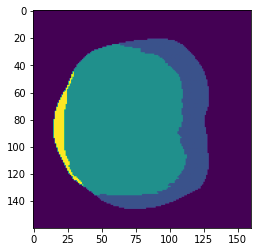

In [18]:
plt.imshow(Y_T[7])

In [19]:
Y_T_c=to_categorical(Y_T,5)
Y_V_c=to_categorical(Y_V,5)

In [20]:
np.unique(Y_T_c[0])

array([0., 1.], dtype=float32)

In [21]:
X_T=np.array(X_T)
Y_T_c=np.array(Y_T_c)
X_V=np.array(X_V)
Y_V_c=np.array(Y_V_c)

In [22]:
X_T=np.expand_dims(X_T, axis=-1)
X_V=np.expand_dims(X_V, axis=-1)

In [23]:
print(X_T.shape , Y_T_c.shape ,X_V.shape, Y_V_c.shape )

(722, 160, 160, 1) (722, 160, 160, 5) (76, 160, 160, 1) (76, 160, 160, 5)


In [24]:
import random
def Data_generator_train(X,y, batch_size=8):   
    while True:               
          for start in range(0, X.shape[0], batch_size):
              x_batch = []
              y_batch = []
              end = min(start + batch_size, X.shape[0])
              ids_batch = X[start:end]
              for idd in range(start,end):           
                   a=random.randint(0,2)
                   if a==0:
                      image =np.fliplr(X[idd]) 
                      label =np.fliplr(y[idd])
                   if a==1:
                     image =np.flipud(X[idd]) 
                     label =np.flipud(y[idd])
                   elif a==2:
                     image =(X[idd]) 
                     label =(y[idd])                
                   x_batch.append(image)
                   y_batch.append(label)               
              x_batch= np.array(x_batch)
              y_batch= np.array(y_batch)                                           
              yield x_batch, y_batch


In [25]:
m,b=next(iter(Data_generator_train(X_T,Y_T_c)))

print(m.shape)
print(b.shape)

(8, 160, 160, 1)
(8, 160, 160, 5)


In [26]:
import random
def Data_generator_test(X,y, batch_size=1):   
    while True:               
          for start in range(0, X.shape[0], batch_size):
              x_batch = []
              y_batch = []
              end = min(start + batch_size, X.shape[0])
              ids_batch = X[start:end]
              for idd in range(start,end):           
                image =(X[idd]) 
                label =(y[idd])                
                x_batch.append(image)
                y_batch.append(label)               
              x_batch= np.array(x_batch)
              y_batch= np.array(y_batch)                                           
              yield x_batch, y_batch


In [27]:
m,b=next(iter(Data_generator_test(X_V,Y_V_c)))

print(m.shape)
print(b.shape)

(1, 160, 160, 1)
(1, 160, 160, 5)


In [28]:
model= sm.Unet('resnet34', classes=5, activation='softmax', encoder_weights=None, input_shape=(160, 160, 1))

In [29]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 160, 160, 1) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 160, 160, 1)  3           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 166, 166, 1)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 80, 80, 64)   3136        zero_padding2d[0][0]             
____________________________________________________________________________________________

In [30]:
optim = tf.keras.optimizers.Adam(lr =0.0008)
dice_loss = sm.losses.DiceLoss() 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), 'accuracy']

In [31]:
model.compile(optim, total_loss, metrics)

In [32]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,CSVLogger

model_checkpoint = ModelCheckpoint('/content/drive/My Drive/unet_resnet34_DWI/'+'unet_resnet34_fold10.h5', save_best_only=True,save_weights_only=True, verbose=2, monitor='val_f1-score',mode='max')
csv_logger = CSVLogger('/content/drive/My Drive/unet_resnet34_DWI/'+'unet_resnet34_fold10.csv', append=True)

In [33]:
def step_decay(epoch):
     
     initAlpha = 0.0008
     factor = .9
     dropEvery = 30
     alpha = initAlpha * (factor ** np.floor((1 + epoch) / dropEvery))
     return float(alpha)

In [34]:
batch_size =8
TrainSteps = len(X_T)  / batch_size
ValSteps   = len(X_V)

In [55]:
model.load_weights('/content/drive/My Drive/unet_resnet34_ADC/unet_resnet34_fold10.h5')

In [36]:
scores=model.evaluate(X_V,Y_V_c , batch_size=1)
print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric, value))

76/76 [==============================] - 1s 10ms/step - loss: 0.9967 - iou_score: 0.4886 - f1-score: 0.5102 - accuracy: 0.7062
Loss: 0.99674
mean <segmentation_models.metrics.IOUScore object at 0x7f69170bb2d0>: 0.4886
mean <segmentation_models.metrics.FScore object at 0x7f69170bb5d0>: 0.51019
mean accuracy: 0.70617


In [99]:
img= nib.load("/content/ADD_crop.nii")
lbl_img = img.get_fdata(caching='unchanged') 

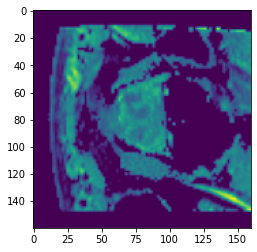

In [100]:
plt.imshow(lbl_img[:,:,8])

In [101]:
img_label= nib.load("/content/label.nii")
lbl_img_label = img_label.get_fdata(caching='unchanged') 

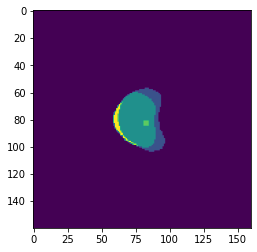

In [102]:
plt.imshow(lbl_img_label[:,:,8])

In [103]:
X_Tt=[]
for j in range(0,19):
  img=lbl_img[:,:,j]
  X_Tt.append(img)

X_Tt=np.array(X_Tt)
X_Ttt=np.expand_dims(X_Tt, axis=-1)  

In [104]:
p=model.predict(X_Ttt)
p.shape
# y=Y_V_c

(19, 160, 160, 5)

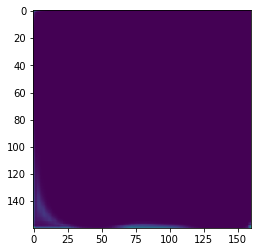

In [105]:
plt.imshow(p[9,:,:,3])

In [95]:
pred=np.argmax(p, axis=-1)

In [96]:
pred.shape

(19, 160, 160)

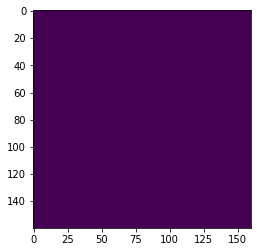

In [98]:
plt.imshow(pred[7])

In [ ]:
from scipy.spatial.distance import directed_hausdorff


def Average(lst):
    return sum(lst) / len(lst)



HD=[]
for i in range(0,76):
  hd=directed_hausdorff(p[i,:,:,0], y[i,:,:,0])
  HD.append(hd[0])

print(len(HD))
print(Average(HD))


76
0.019194448519907835


/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:456: UserWarning: you are shuffling a '_memoryviewslice' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  result = _hausdorff.directed_hausdorff(u, v, seed)


In [ ]:
from scipy.spatial.distance import directed_hausdorff


def Average(lst):
    return sum(lst) / len(lst)



HD=[]
for i in range(0,76):
  hd=directed_hausdorff(p[i,:,:,1], y[i,:,:,1])
  HD.append(hd[0])

print(len(HD))
print(Average(HD))


76
0.010939579749710176


/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:456: UserWarning: you are shuffling a '_memoryviewslice' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  result = _hausdorff.directed_hausdorff(u, v, seed)


In [ ]:
from scipy.spatial.distance import directed_hausdorff


def Average(lst):
    return sum(lst) / len(lst)



HD=[]
for i in range(0,76):
  hd=directed_hausdorff(p[i,:,:,2], y[i,:,:,2])
  HD.append(hd[0])

print(len(HD))
print(Average(HD))


/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:456: UserWarning: you are shuffling a '_memoryviewslice' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  result = _hausdorff.directed_hausdorff(u, v, seed)


76
0.00892659435778082


In [ ]:
from scipy.spatial.distance import directed_hausdorff


def Average(lst):
    return sum(lst) / len(lst)



HD=[]
for i in range(0,76):
  hd=directed_hausdorff(p[i,:,:,3], y[i,:,:,3])
  HD.append(hd[0])

print(len(HD))
print(Average(HD))


/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:456: UserWarning: you are shuffling a '_memoryviewslice' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  result = _hausdorff.directed_hausdorff(u, v, seed)


76
0.0004864458746184421


In [ ]:
from scipy.spatial.distance import directed_hausdorff


def Average(lst):
    return sum(lst) / len(lst)



HD=[]
for i in range(0,76):
  hd=directed_hausdorff(p[i,:,:,4], y[i,:,:,4])
  HD.append(hd[0])

print(len(HD))
print(Average(HD))


/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:456: UserWarning: you are shuffling a '_memoryviewslice' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  result = _hausdorff.directed_hausdorff(u, v, seed)


76
0.0006053564318555439


In [ ]:
pred=np.argmax(p, axis=-1)
ytrue=np.argmax(y, axis=-1)

In [ ]:
Pred=pred.flatten()
Ytrue=ytrue.flatten()

In [ ]:
Ytrue.shape

(1945600,)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Pred, Ytrue, digits=4))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     1.0000    0.7062    0.8278   1945600
           1     0.0000    0.0000    0.0000         0
           2     0.0000    0.0000    0.0000         0
           3     0.0000    0.0000    0.0000         0
           4     0.0000    0.0000    0.0000         0

    accuracy                         0.7062   1945600
   macro avg     0.2000    0.1412    0.1656   1945600
weighted avg     1.0000    0.7062    0.8278   1945600



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
